# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


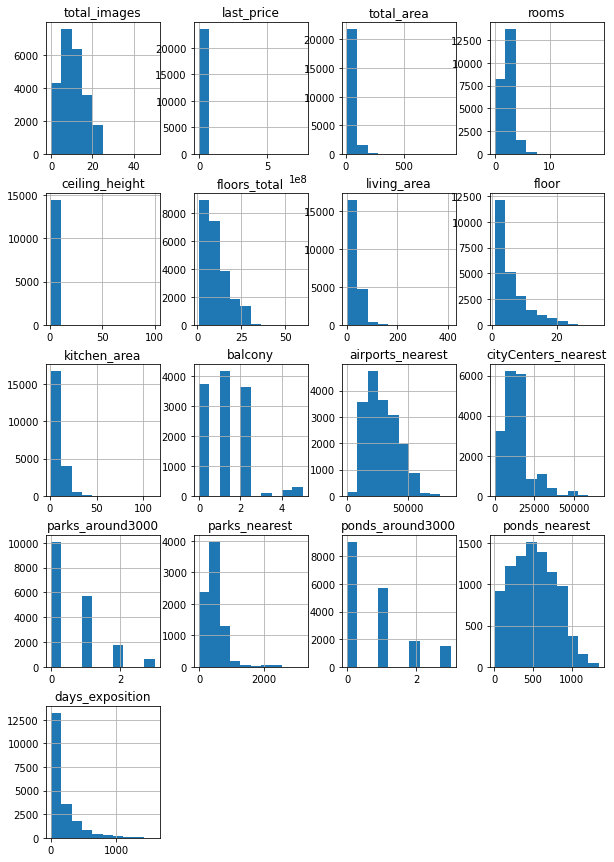

In [2]:
# Проект делаю локально в VSCode
csv_path = 'real_estate_data.csv'
if not os.path.exists(csv_path):
    csv_path = '/datasets/' + csv_path

data = pd.read_csv(csv_path, sep='\t')
display(data.info())
display(data.head())
data.hist( figsize=(10, 15));

Данные загрузились корректно после замены разделителя на табуляцию.
Размер датасета более 20 тыс - кажется, это достаточный размер для изучения (но точных методов оценки этого я не помню - недеюсь, мы ещё будем их проходить.).

Некоторые гистограммы слишком скучены вокруг одного значения. Нужно будет рассмореть более узкий их range и удалить их рассмотрения в случае если распределение совсем мало (то есть оно не варьируется и ничего не решает).

### Выполните предобработку данных

#### Рассмотрим типы данных в каждом столбце

In [3]:
(data.isna().sum()/len(data)).sort_values(ascending=False)

is_apartment            0.882906
parks_nearest           0.659100
ponds_nearest           0.615596
balcony                 0.486054
ceiling_height          0.387991
airports_nearest        0.233850
cityCenters_nearest     0.232879
ponds_around3000        0.232837
parks_around3000        0.232837
days_exposition         0.134225
kitchen_area            0.096122
living_area             0.080299
floors_total            0.003629
locality_name           0.002068
total_images            0.000000
last_price              0.000000
studio                  0.000000
floor                   0.000000
rooms                   0.000000
first_day_exposition    0.000000
total_area              0.000000
open_plan               0.000000
dtype: float64

Рассмотрим пропущенные данные.

In [4]:
def describe_field(data, field_name):
    display (f"amount of NaN is {data[field_name].isna().sum()}, {(data[field_name].isna().sum() / len(data) * 100).astype('int')}%")
    display(data[field_name].describe())

In [5]:
display((data['is_apartment'].value_counts()))
describe_field(data, 'is_apartment')

False    2725
True       50
Name: is_apartment, dtype: int64

'amount of NaN is 20924, 88%'

count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object

Апартаменты это или квартира - важный признак в плане налогов и последующей возможной перепродажи.

С одной стороны люди, не интересовавшиеся раньше апартами могут вообще не знать, что это такое и не придать значение этому полю. То есть можно было бы по умолчанию считать, что NaN - это квартира.

С другой стороны апартаменты могут быть менее желательным вариантом для покупателя, и продавцы могут сознательно выдавать апарты за квартиры "забыв" поставить галку. И тогда можно было бы предложить по умолчанию ставить апарты.

Это поле - довольно "чувствительное" по значению. И доля неопределённости слишком велика (20924/23699=88%) - в 88% случаев мы не знаем, человек хитрит, не понимает о чём его спрашивают, или не заметил. Поэтому я бы это поле предложил далее не учитывать (сделав его в будущих версиях сервиса его обязательным для заполнения и с пояснением для заполняющего).


In [6]:
data['is_apartment'] = data['is_apartment'].fillna (False)

In [7]:
describe_field (data, 'parks_nearest')

'amount of NaN is 15620, 65%'

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

15620/23699 значений пустые. В то же время наличие парка - конкурентное преимущество, и продавец вряд ли захотел бы его скрывать. Вероятно парка радом нет. Исходя из максимальной указанной удалённости в 3км - заменим NaN на 30 км (и перепроверим число пустых). Это стоит сделать, чтобы можно было рассчитывать корреляции между значениями.

In [8]:
far_far_away = 30000

data['parks_nearest'] = data['parks_nearest'].fillna (far_far_away)


сделаем то же с прудами

In [9]:
describe_field (data, 'ponds_nearest')

'amount of NaN is 14589, 61%'

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [10]:
data['ponds_nearest'] = data['ponds_nearest'].fillna (far_far_away)

Пропуски балконов переделаем в отсутствие балконов

In [11]:
data['balcony'] = data['balcony'].fillna(0)
display(data['balcony'].isna().sum())


0

In [12]:
#высота потолков (м)
describe_field (data, 'ceiling_height')

'amount of NaN is 9195, 38%'

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Высоту потолков заменим медианой (она равноценна среднему при отсутствии всплесков, но всё же надёжнее, наверное использовать медиану?). Те, у кого она больше среднего постараются это указать, им невыгодно это умалчивать.

Не понятно, что делать с квартирами высотой 1 м? Таких квартир не бывает. Как мниимум, пока отдельно это отметим.

In [13]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [14]:
#расстояние до ближайшего аэропорта в метрах (м)
describe_field (data, 'airports_nearest')

'amount of NaN is 5542, 23%'

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

если не указал - значит далеко, заменим пропуски 100 км (чуть больше, чем максимум)

In [15]:
data['airports_nearest'] = data['airports_nearest'].fillna (100000)

In [16]:
#расстояние до центра города (м)
describe_field (data, 'cityCenters_nearest')

'amount of NaN is 5519, 23%'

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Это крайне важный показатель. При этом, он должен заполняться автоматически. В этом месте пишу багу разработчикам - почему есть пропуски?

Заполнять его средним нельзя, кажется. Подгонять такой важный параметр кажется неправильным - пусть уж лучше вылезут NaN в рассчётах. Пожалуйста, поправьте меня, если неправ.

Удалять 23% данных тоже кажется неверным.

Хм. Почему в фичах нет расстояния до ближайшего метро? Это же "архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет". Также пишу багу продакт-менеджеру. Это тоже довольно важный параметр, который должен рассчитываться автоматически (для Питера, не для области).

In [17]:
#число водоёмов в радиусе 3 км
describe_field (data, 'ponds_around3000')
describe_field (data, 'parks_around3000')

'amount of NaN is 5518, 23%'

count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

'amount of NaN is 5518, 23%'

count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

Эти почему-то хочется заполнить медианой, т. к. не так важны по сравнению с метрами до пруда/парка.

In [19]:
#сколько дней было размещено объявление (от публикации до снятия)
describe_field (data, 'days_exposition')

'amount of NaN is 3181, 13%'

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Это тоже должно заполняться автоматически. Пишу багу разработчикам - почему пропуски? Заполняю медианой.

In [21]:
describe_field (data, 'kitchen_area')

'amount of NaN is 2278, 9%'

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Скорее всего те, кто не указал - скрывают малую кухню. Я бы указал квартиль Q1. Но презумция невиновности, поэтому использую медиану.

In [22]:

kitchen_per_total_avg = (data[~data['kitchen_area'].isna()]['kitchen_area'] / data[~data['kitchen_area'].isna()]['total_area']).median()

data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data[data['kitchen_area'].isna()]['total_area']*kitchen_per_total_avg

In [23]:
display("жилая площадь:")
describe_field (data, 'living_area')
display("общая площадь:")
describe_field (data, 'total_area')

'жилая площадь:'

'amount of NaN is 1903, 8%'

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

'общая площадь:'

'amount of NaN is 0, 0%'

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Очень важный показатель. Стоило бы сделать обязательным при заполнении.

При этом общая площадь всегда указана. Рассчитаем средний коэффициент для тех значений, для которых и жилая и общая заполнена.

Затем пустые жилые вычислим из общих с учётом вычисленного коэффициента.

In [24]:
living_per_total_avg = (data[~data['living_area'].isna()]['living_area'] / data[~data['living_area'].isna()]['total_area']).median()

data.loc[data['living_area'].isna(), 'living_area'] = data[data['living_area'].isna()]['total_area']*living_per_total_avg

In [25]:
#всего этажей в доме
describe_field (data, 'floors_total')

'amount of NaN is 86, 0%'

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Сранно, что нет поля "последний" этаж. Наверное его стоило бы вычислить. Но нужен последний этаж, а он не всегда есть. Можно было бы предположить, что раз не указали - то этаж последний (ну либо забыли указать). Буду пессимистом в данном случае и назначу последним - этаж квартиры.

In [26]:
data.loc[data['floors_total'].isna(), 'floors_total'] = data[data['floors_total'].isna()]['floor']

In [27]:
#название населённого пункта
data['locality_name'] = data['locality_name'].fillna('unknown_locality')

In [28]:
describe_field (data, 'ponds_around3000')

'amount of NaN is 5518, 23%'

count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [29]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(data['ponds_around3000'].median())

In [30]:
describe_field (data, 'parks_around3000')

'amount of NaN is 5518, 23%'

count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [31]:
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median())

####	Рассмотрим типы данных в каждом столбце

In [32]:
data.info()
data[~data.isna()].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,...,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,30000.0,0.0,30000.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,False,...,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,90.289724,9,False,...,27.413793,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,...,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Следующие поля имеют неверный тип, он должен быть исправлен.
- Поле first_day_exposition должно стать полем даты.
- floors_total ->int64
- is_apartment -> bool
- parks_around3000, ponds_around3000  -> int64
- days_exposition -> int64

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
#data['days_exposition'] = data['days_exposition'].astype('int')
data['locality_name'] = data['locality_name'].astype('string')


проверим:

In [34]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0,30000.0,0,30000.0,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.289724,9,False,...,27.413793,0.0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


Исправим явные и неявные дубликаты

In [35]:
display(data.duplicated().sum())
display(data['locality_name'].unique())

0

<StringArray>
[          'Санкт-Петербург',            'посёлок Шушары',
 'городской посёлок Янино-1',         'посёлок Парголово',
            'посёлок Мурино',                 'Ломоносов',
                 'Сертолово',                  'Петергоф',
                    'Пушкин',           'деревня Кудрово',
 ...
   'деревня Большое Рейзино',   'деревня Малая Романовка',
       'поселок Дружноселье',            'поселок Пчевжа',
       'поселок Володарское',            'деревня Нижняя',
 'коттеджный посёлок Лесное',         'деревня Тихковицы',
    'деревня Борисова Грива',      'посёлок Дзержинского']
Length: 365, dtype: string

Сначала попробуем убрать лишние слова и отсортировать населённые пункты по алфавиту - так будет легче сравнивать.

In [36]:
data['locality_name_tmp'] = (data[data['locality_name']!='unknown_locality']['locality_name']
                         .str.replace('ё', 'е')
                         .str.replace(r'^[^А-Я]+', '', case=True, regex=True)
)
display(data['locality_name_tmp'].sort_values().unique())

<StringArray>
[      'Агалатово', 'Александровская',      'Алексеевка',          'Аннино',
             'Аро',        'Барышево',          'Батово',        'Бегуницы',
       'Белогорка',      'Белоостров',
 ...
        'Шугозеро',             'Шум',          'Шушары',         'Щеглово',
            'Юкки',          'Ялгино',       'Яльгелево',       'Ям-Тесово',
         'Янино-1',              <NA>]
Length: 306, dtype: string

В самих названиях дубликатов найти не удалось.

Посмотрим, так же на слова перед названиями

In [37]:
data['locality_name_tmp'] = (data[data['locality_name']!='unknown_locality']['locality_name']
                         .str.replace('ё', 'е')
                         .str.replace(r'[А-Я].+', '', case=True, regex=True)
)
data['locality_name_tmp'].sort_values().unique()

<StringArray>
[                                          '',
                         'городской поселок ',
                                   'деревня ',
                        'коттеджный поселок ',
                                   'поселок ',
                   'поселок городского типа ',
             'поселок городского типа имени ',
       'поселок при железнодорожной станции ',
                           'поселок станции ',
 'садоводческое некоммерческое товарищество ',
                      'садовое товарищество ',
                                      'село ',
                                         <NA>]
Length: 13, dtype: string

Обновим имена. Удалим временный столбец.

In [38]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [39]:
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество')

In [40]:
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок при железнодорожной станции')

In [ ]:
village_duplicates = ['городской поселок', 'деревня', 'коттеджный поселок', 'поселок городского типа', 'поселок городского типа имени', 'поселок при железнодорожной станции', 'поселок станции']
for s in village_duplicates:
    data['locality_name'] = data['locality_name'].str.replace(s, 'поселок')


In [42]:
data = data.drop('locality_name_tmp', axis=1)

In [ ]:
data.loc[data['locality_name'].str.contains('Рябово') & data['locality_name'].notna(), 'locality_name']

1611     поселок Рябово
3930     поселок Рябово
6465     поселок Рябово
11118    поселок Рябово
Name: locality_name, dtype: string

In [44]:
display(data.head())
display(data.info())
display(f"full duplicates: {data.duplicated().sum()}")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,11.000000,2.0,поселок Шушары,12817.0,18603.0,0,30000.0,0,30000.0,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.289724,9,False,...,27.413793,0.0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

None

'full duplicates: 0'

#### Общий вывод по итогам предобработки.

1. Оставлены пропуски days_exposition, т. к. они нормальны для ещё не проданных квартир
1. Обработаны (заполнены) пропуски в следующих полях:
    1. is_apartment
    1. parks_nearest
    1. ponds_nearest
    1. balcony
    1. ceiling_height
    1. airports_nearest
    1. kitchen_area (вычислено из общей площади, по типичной пропорции)
    1. living_area (вычислено из общей площади, по типичной пропорции)
    1. floors_total
    1. locality_name
    1. ponds_around3000
    1. parks_around3000
1. Следующие типы данных приведены к корректным 
    1. Поле first_day_exposition должно стать полем даты.
    1. floors_total ->int64
    1. is_apartment -> bool
    1. parks_around3000, ponds_around3000  -> int64
    1. days_exposition -> int64
1. Количество записей в таблице не уменьшилось, т. к. полных дубликатов нет.

### Добавьте в таблицу новые столбцы

In [45]:
data['last_price_m2'] = (data ['last_price']/data['total_area']).round(2)
data['first_day_exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['first_day_exposition_day'] = data['first_day_exposition'].dt.day
data['first_day_exposition_month'] = data['first_day_exposition'].dt.month
data['first_day_exposition_year'] = data['first_day_exposition'].dt.year


def floor_type (flat):
    if flat['floor'] == 1: return "первый"
    if flat['floor'] == flat['floors_total']: return "последний"
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1)

data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,first_day_exposition_weekday,first_day_exposition_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,2,755.0,NaN,120370.37,3,7,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0,30000.0,81.0,82920.79,1,4,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,2,574.0,558.0,92785.71,3,20,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.289724,9,False,...,3,234.0,424.0,408176.10,4,24,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,1,48.0,121.0,100000.00,1,19,6,2018,другой,8.0


Добавлены поля:
1. стоимость m2
1. день недели
1. день месяца
1. месяц
1. год
1. тип этажа (первый/последний/другое)
1. расстояние до города в км


### Проведите исследовательский анализ данных

In [46]:
import matplotlib.pyplot as plt

display(data['total_area'].describe())

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Минимальное значение в 12 м2 для квартиры видится как очень редкое, но это можеть быть комната или часть квартиры, которые тоже вполне могут продавать. Максимальное значение в 900 м2 тоже видится, наверное, реальным для загородного дома.

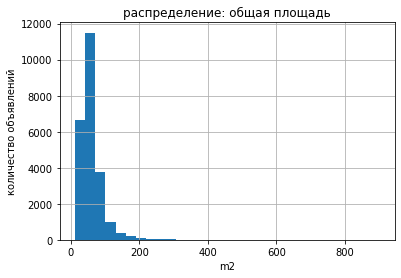

In [47]:
plt.title('распределение: общая площадь')
plt.ylabel("количество объявлений")
plt.xlabel("m2")

data['total_area'].hist(bins=30, range=(12,900));

- комментарий: посмотрим на общую площадь
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: сжато влево, 0-200
- наличие аномалий: посмотрим на следующих графиках

 После 300м2 гистограмма сводится к погрешности, можно отрезать этот хвост:


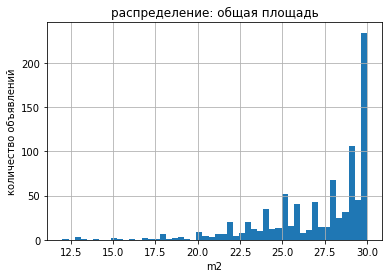

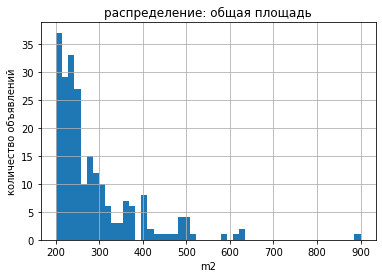

In [48]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: общая площадь')

data['total_area'].hist(bins=50, range=(12,30));
plt.show()

plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: общая площадь')
data['total_area'].hist(bins=50, range=(201,900));

- комментарий: посмотрим на общую площадь по краям
- вид распределения данных: на краях этого не понять
- наличие аномалий: Оставим от 20 до 500, остальное удалим.

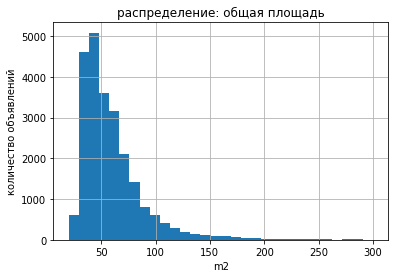

In [49]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: общая площадь')
data = data.drop( data[(data['total_area'] < 20) | (data['total_area'] > 300)].index )
data['total_area'].hist(bins=30);

- комментарий: график после отсечений
- вид распределения данных: похоже на распределение Пуассна
- основной диапазон, описательные статистики: 20-500
- наличие аномалий: не заметно

Рассмотрим жилую площадь.

In [50]:
display(data['living_area'].describe())

count    23611.000000
mean        34.100925
std         19.763216
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        250.000000
Name: living_area, dtype: float64

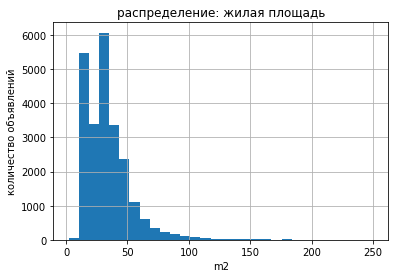

In [51]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: жилая площадь')
data['living_area'].hist(bins=30, range=(2,250));

- комментарий: посмотрим на жилую площадь
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: сжато влево, 0-250
- наличие аномалий: посмотрим на следующих графиках


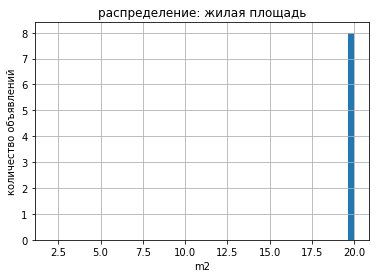

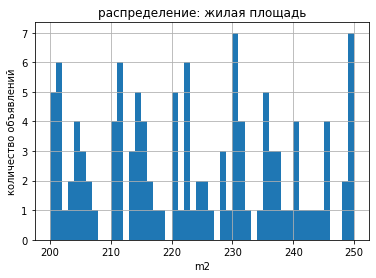

In [52]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: жилая площадь')
data['total_area'].hist(bins=50, range=(2,20))
plt.show()

plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: жилая площадь')
data['total_area'].hist(bins=50, range=(200,250));

- комментарий: посмотрим на жилую площадь по краям
- вид распределения данных: на краях этого не понять
- наличие аномалий: Оставим от 20 до 200, остальное удалим.

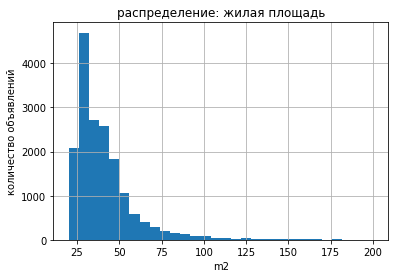

In [53]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: жилая площадь')

data = data.drop( data[(data['living_area'] < 20) | (data['living_area'] > 200)].index )
data['living_area'].hist(bins=30);

- комментарий: график после отсечений
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 20-200
- наличие аномалий: не заметно

Кухни

In [54]:
display(data['kitchen_area'].describe())
 

count    17135.000000
mean        10.950087
std          6.218835
min          2.000000
25%          7.100000
50%          9.482759
75%         12.400000
max        107.000000
Name: kitchen_area, dtype: float64

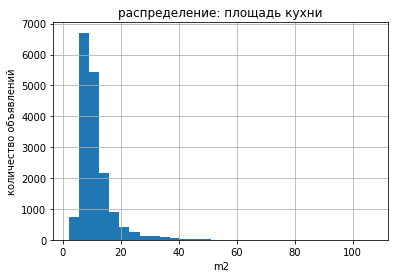

In [55]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: площадь кухни')
data['kitchen_area'].hist(bins=30);

- комментарий: посмотрим на кухни
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: сжато влево, 0-100
- наличие аномалий: Удалим кухни после 40 м2. Маленькие кухни не будем трогать.

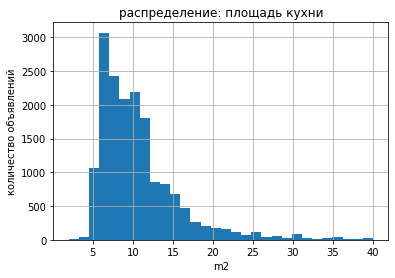

In [56]:
plt.ylabel("количество объявлений")
plt.xlabel("m2")
plt.title('распределение: площадь кухни')
data = data.drop( data[data['kitchen_area'] > 40].index )
data['kitchen_area'].hist(bins=30);

- комментарий: график после отсечений
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 3-40
- наличие аномалий: не заметно

цена объекта

In [57]:
display(data['last_price'].describe())

count    1.701700e+04
mean     7.149470e+06
std      8.257778e+06
min      4.300000e+05
25%      3.995000e+06
50%      5.370000e+06
75%      7.800000e+06
max      3.300000e+08
Name: last_price, dtype: float64

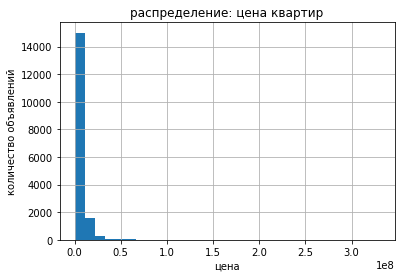

In [58]:
plt.title('распределение: цена квартир')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data['last_price'].hist(bins=30);

В графике цен на квартиры 1-2-3-4 комнатные квартиры свалены в кучу - это не очень хорошо. Лучше посмотрим на распределение цен за м2.

count    1.701700e+04
mean     9.817595e+04
std      5.022537e+04
min      7.962960e+03
25%      7.441860e+04
50%      9.266667e+04
75%      1.131725e+05
max      1.736842e+06
Name: last_price_m2, dtype: float64

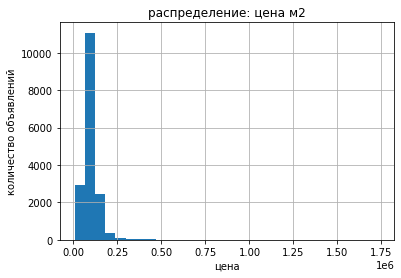

In [59]:
display(data['last_price_m2'].describe())
plt.title('распределение: цена м2')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data['last_price_m2'].hist(bins=30);


- комментарий: посмотрим на цену за м2
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: сжато влево, 0-1.75*10^6
- наличие аномалий: посмотрим на следующих графиках

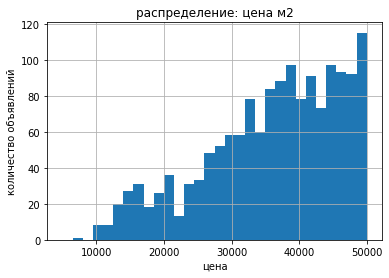

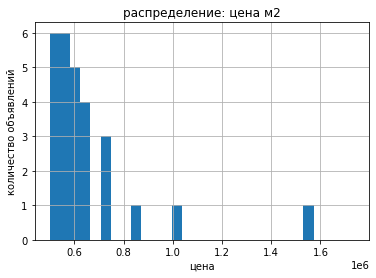

In [60]:
plt.title('распределение: цена м2')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data['last_price_m2'].hist(bins=30, range=(5000, 50000))
plt.show()

plt.title('распределение: цена м2')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data['last_price_m2'].hist(bins=30, range=(500000, 1.736842e+06));

- комментарий: посмотрим на цену за м2 по краям
- вид распределения данных: на краях этого не понять
- наличие аномалий: Оставим от 0 до 0.8e+06, остальное удалим.

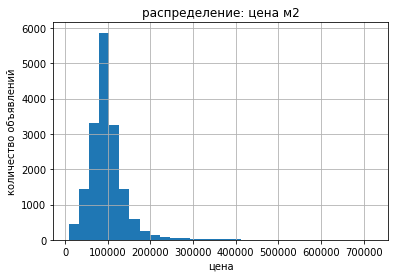

In [61]:
plt.title('распределение: цена м2')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data = data.drop( data[data['last_price_m2'] > 0.8e+06].index )
data['last_price_m2'].hist(bins=30);

Ещё подкорректируем до 400000:

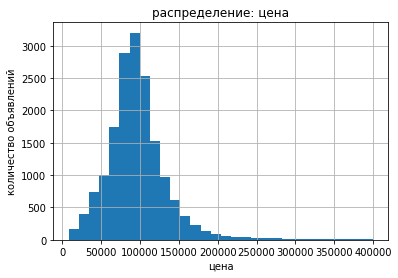

In [62]:
plt.title('распределение: цена')
plt.ylabel("количество объявлений")
plt.xlabel("цена")
data = data.drop( data[data['last_price_m2'] > 400000].index )
data['last_price_m2'].hist(bins=30);

- комментарий: график после отсечений
- вид распределения данных: больше похоже на нормальное распределение, чем на Пуассона
- основной диапазон, описательные статистики: 10000-400000
- наличие аномалий: не заметно

количество комнат

count    16966.000000
mean         2.454379
std          0.935472
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

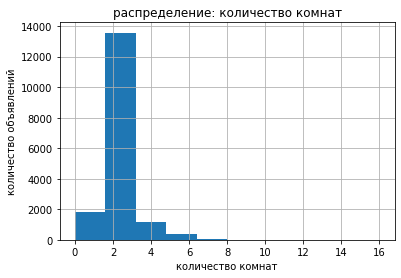

In [63]:
display(data['rooms'].describe())
plt.title('распределение: количество комнат')
plt.ylabel("количество объявлений")
plt.xlabel('количество комнат')
data['rooms'].hist(bins=10);

- комментарий: посмотрим на комнаты
- вид распределения данных: не понятно, отдалённо похоже на Пуассона
- основной диапазон, описательные статистики: сжато влево, 1-8
- наличие аномалий: аномалий не заметно, ничего отрезать не будем

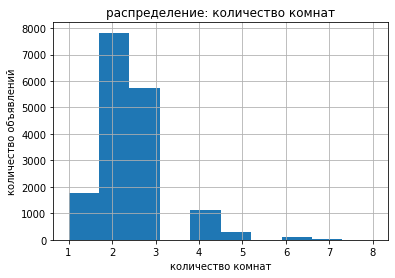

In [64]:
plt.title('распределение: количество комнат')
plt.ylabel("количество объявлений")
plt.xlabel('количество комнат')
data = data.drop( data[(data['rooms'] < 1) | (data['rooms'] > 8)].index )
data['rooms'].hist();

- наличие аномалий: аномалий не заметно, ничего отрезать не будем

высота потолков

count    16911.000000
mean         2.737348
std          0.834333
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

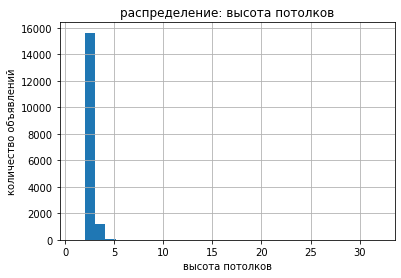

In [65]:
display(data['ceiling_height'].describe())
plt.title('распределение: высота потолков')
plt.ylabel("количество объявлений")
plt.xlabel('высота потолков')
data['ceiling_height'].hist(bins=30);

- комментарий: посмотрим на потолки
- вид распределения данных: сложно скадать
- основной диапазон, описательные статистики: сжато влево, 0-5
- наличие аномалий: посмотрим на следующих графиках

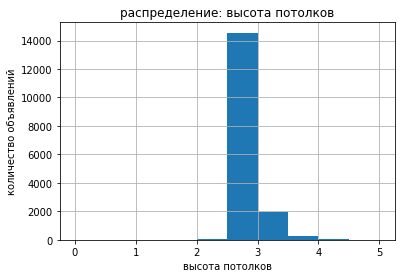

In [66]:
plt.title('распределение: высота потолков')
plt.ylabel("количество объявлений")
plt.xlabel('высота потолков')
data['ceiling_height'].hist(bins=10, range=(0,5));

- комментарий: посмотрим на потолки прицельно слева
- вид распределения данных: похоже на Пуассона
- наличие аномалий: Оставим от 2 до 5, остальное удалим.

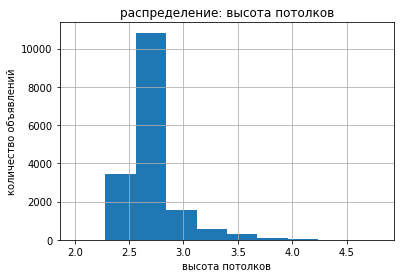

In [67]:
data = data.drop( data[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 5)].index )
plt.title('распределение: высота потолков')
plt.ylabel("количество объявлений")
plt.xlabel('высота потолков')
data['ceiling_height'].hist(bins=10);

- комментарий: график после отсечений
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 2-4
- наличие аномалий: не заметно

тип этажа квартиры 

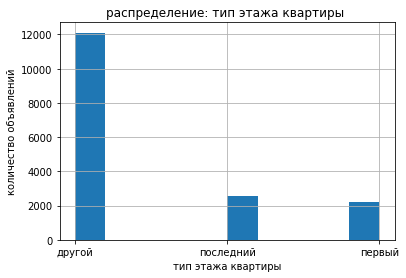

In [68]:
plt.title('распределение: тип этажа квартиры ')
plt.ylabel("количество объявлений")
plt.xlabel('тип этажа квартиры')
data['floor_type'].hist();

- комментарий: посмотрим на тип этажа квартиры
- вид распределения данных: похоже на распределение Пуассона
- наличие аномалий: аномалий не видно, оставляем как есть

count    16884.000000
mean         9.936686
std          6.217872
min          1.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         60.000000
Name: floors_total, dtype: float64

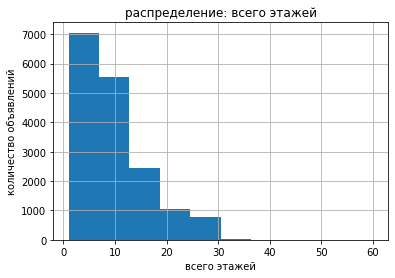

In [69]:
display(data['floors_total'].describe())
plt.title('распределение: всего этажей')
plt.ylabel("количество объявлений")
plt.xlabel('всего этажей')
data['floors_total'].hist();


- комментарий: посмотрим на этажи
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: сжато влево, 0-30
- наличие аномалий: посмотрим на следующих графиках

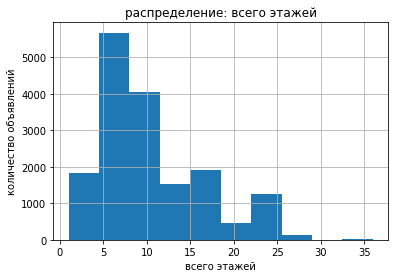

In [70]:
data = data.drop( data[data['floors_total'] > 40].index )
plt.title('распределение: всего этажей')
plt.ylabel("количество объявлений")
plt.xlabel('всего этажей')
data['floors_total'].hist(bins=10);

ещё скорректируем:

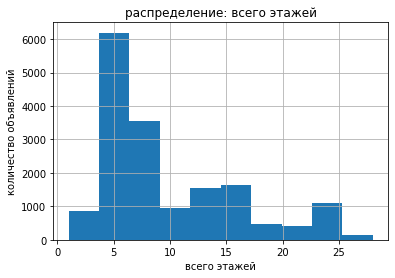

In [71]:
data = data.drop( data[data['floors_total'] > 30].index )
plt.title('распределение: всего этажей')
plt.ylabel("количество объявлений")
plt.xlabel('всего этажей')
data['floors_total'].hist(bins=10);

- комментарий: график после отсечений
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 0-25
- наличие аномалий: не заметно

расстояние до центра города в метрах

count    13266.000000
mean     13683.148801
std       8724.781277
min        181.000000
25%       8297.000000
50%      12658.000000
75%      15983.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

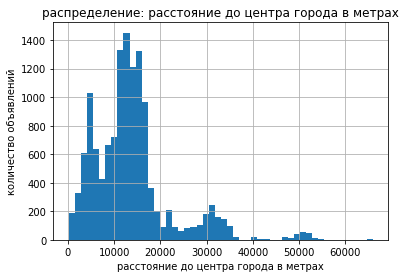

In [72]:
display(data['cityCenters_nearest'].describe())
plt.title('распределение: расстояние до центра города в метрах')
plt.ylabel("количество объявлений")
plt.xlabel('расстояние до центра города в метрах')

data['cityCenters_nearest'].hist(bins=50);

- комментарий: посмотрим на расстояние до центра города в метрах
- вид распределения данных: похоже на распределение Пуассона, либо на смесь нескольких распределений
- основной диапазон, описательные статистики: сжато влево, 0-60км
- наличие аномалий: аномалий не видно, резать ничего не будем

проще проанализировать в км

count    13266.000000
mean        13.676918
std          8.732863
min          0.000000
25%          8.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest_km, dtype: float64

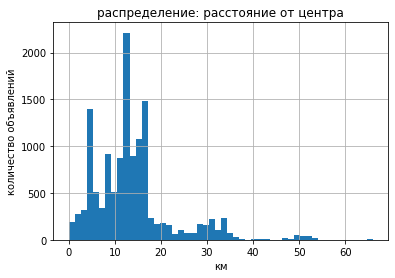

In [73]:
display(data['cityCenters_nearest_km'].describe())
plt.title('распределение: расстояние от центра')
plt.ylabel("количество объявлений")
plt.xlabel('км')
data['cityCenters_nearest_km'].hist(bins=50);

- комментарий: И 0 км от центра, и 66 (для Ленобласти) выглядит нормально: "с севера на юг в пределах КАД — 32 км (за пределами КАД — 52 км), с северо-запада на юго-восток за пределами КАД,— около 90 км". Даже те, кто живёт в области могут интерпретировать "расстояние до центра города (м)" как от центра Питера. Можно было бы предложить продакт-менеджеру явно уточнить/добавить поля "от центра Питера" и "от центра населённого пункта".
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 0-55
- наличие аномалий: не заметно


Расстояние до ближайшего парка

count    16861.000000
mean     19181.491489
std      14222.682373
min          1.000000
25%        560.000000
50%      30000.000000
75%      30000.000000
max      30000.000000
Name: parks_nearest, dtype: float64

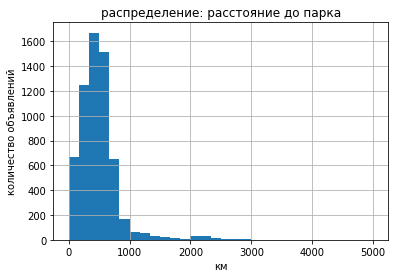

In [74]:
display(data['parks_nearest'].describe())
plt.title('распределение: расстояние до парка')
plt.ylabel("количество объявлений")
plt.xlabel('км')
data['parks_nearest'].hist(bins=30, range=(0,5000));

Тут не знаю, как лучше поступить. NaN были заменены на 30000. Хорошо ли это для рассчётов - не факт. Но и просто выбрасывать так много данных нельзя. Можно впоследствии дать минимальный вес этой фиче.

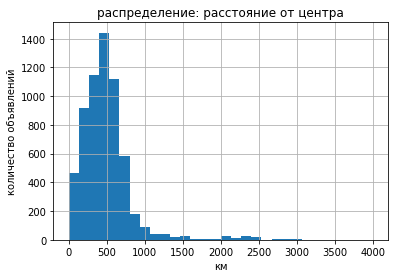

In [75]:
plt.title('распределение: расстояние от центра')
plt.ylabel("количество объявлений")
plt.xlabel('км')
data['parks_nearest'].hist(bins=30, range=(0,4000));

- комментарий: график после приближения
- вид распределения данных: похоже на распределение Пуассона
- основной диапазон, описательные статистики: 0-2500
- наличие аномалий: не заметно, резать ничего не будем


#### Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 

In [76]:
data['days_exposition'].describe()

count    14361.000000
mean       188.554697
std        226.552532
min          1.000000
25%         45.000000
50%        101.000000
75%        242.000000
max       1580.000000
Name: days_exposition, dtype: float64

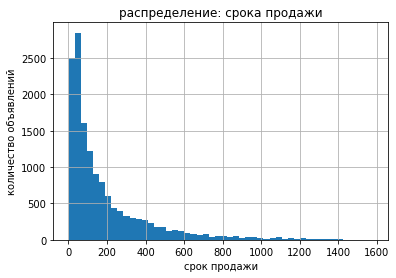

In [77]:
plt.title('распределение: срока продажи')
plt.ylabel("количество объявлений")
plt.xlabel('срок продажи')
data['days_exposition'].hist(bins=50);

Согласно медиане, обычно продажа занимает около 95 дней. От 52 до 203 дней, согласно 1 и 3 квартилям.

Рекордно быстрая продажа была совершена за 1 день, а рекордно долгая длилась 1580 дней.

Можно сказать, что продажа быстрая если она совершена быстрее чем за 52 дня (1й квартиль). Необычно долгой можно назвать продажу выше 3го квартиля в 203 дня. Надеюсь, в задании имелись в виду не аномалии? Если аномалии - то надо будет пересчитать.

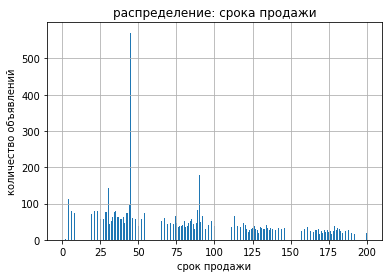

In [78]:
plt.title('распределение: срока продажи')
plt.ylabel("количество объявлений")
plt.xlabel('срок продажи')
data['days_exposition'].hist(bins=500, range=(0,200));

посмотрим, что это за дни:

In [79]:
d = data.groupby(by='days_exposition')['last_price'].count()
d = d [d>100]
d

days_exposition
4.0     112
5.0     101
7.0     149
30.0    143
45.0    571
60.0    460
90.0    178
Name: last_price, dtype: int64

Выявилась интересная закономерность: на 30й, 45й, 60й и 90й день продажи резко возрастают. 
Вероятно, это связано с периодами оплаты объявлений или с периодами их автоматического закрытия системой.
Давайте посмотрим на такие данные детальнее.

In [80]:
d = data.query('days_exposition == 45 or days_exposition == 60')
d['rooms'].value_counts().head()

2    218
3    163
1     53
4     23
5      2
Name: rooms, dtype: int64

<- преимущественно это касается двушек и трёшек

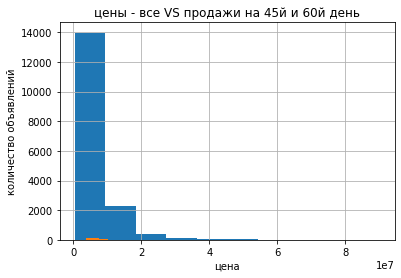

In [81]:
plt.title('цены - все VS продажи на 45й и 60й день')
plt.ylabel("количество объявлений")
plt.xlabel('цена')
data['last_price'].hist();
d['last_price'].hist();


Видно, что данная аномалия касается очень малой части ближе к самому массовому сегменту квартир. Перепроверим на м2:

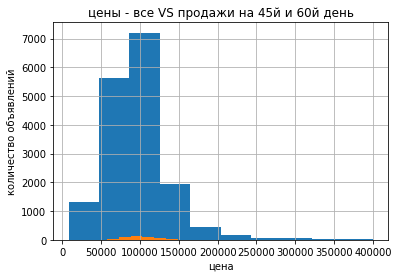

In [82]:
plt.title('цены - все VS продажи на 45й и 60й день')
plt.ylabel("количество объявлений")
plt.xlabel('цена')
data['last_price_m2'].hist();
d['last_price_m2'].hist();

- на м2 то - же самое

In [83]:
d['locality_name'].value_counts().head()

Санкт-Петербург      346
поселок Парголово     11
поселок Шушары        10
поселок Кудрово       10
Сестрорецк             9
Name: locality_name, dtype: Int64

<- видно, что в основном эти аномалии происходят в Питере.

Остальные фичи проанализированы подобным же образом и никаких подозртиельных аномалий выявить пока не удалось.

#### Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

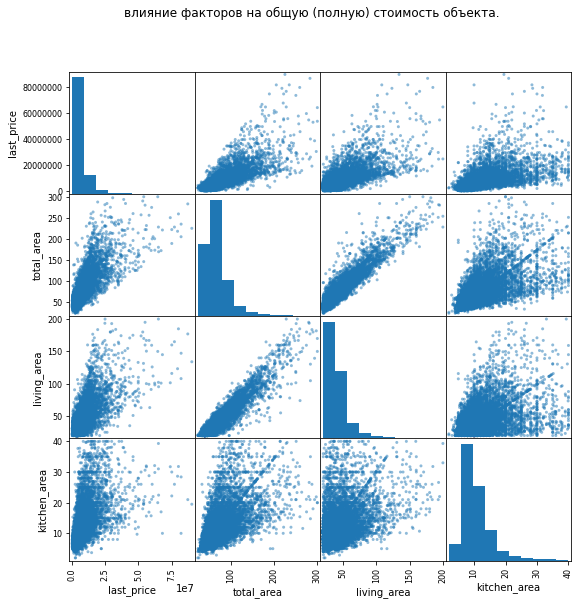

In [84]:
key_features = data [['last_price', 'total_area', 'living_area', 'kitchen_area']]

pd.plotting.scatter_matrix(key_features, figsize=(9,9))
plt.suptitle('влияние факторов на общую (полную) стоимость объекта.')
plt.show()

In [85]:
key_features.corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.770179,0.683420,0.588693
total_area,0.770179,1.000000,0.929888,0.640725
living_area,0.683420,0.929888,1.000000,0.452956
kitchen_area,0.588693,0.640725,0.452956,1.000000


Из построенных графиков и из таблицы видно (максимальная корреляция 0.77), что цена в наибольшей степени зависит от общей площади.

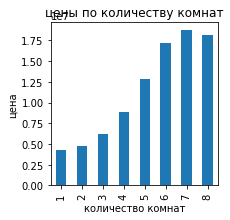

In [86]:
(data
 .groupby(by='rooms')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(3,3), title='цены по количеству комнат', xlabel='количество комнат', ylabel='цена')
)
plt.show()

<- количество комнат также напрямую связано с площадью, поэтому можно в итоге ориентироваться на площадь. Чем больше комнат, тем выше цена.

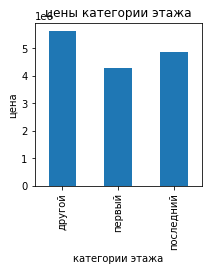

In [87]:
(data
 .groupby(by='floor_type')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(3,3), title='цены категории этажа', xlabel='категории этажа', ylabel='цена')
 )
plt.show()

Из графика видно, что дороже стоят квартиры не на певом и не на последнем этаже. Меньше остальных стоят квартиры на первом этаже.

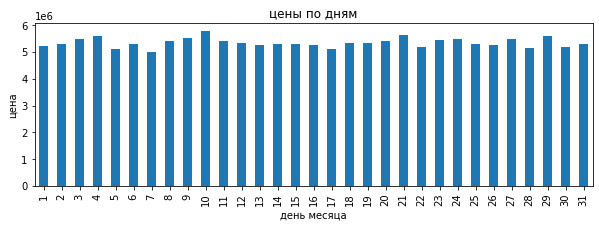

In [88]:
(data
 .groupby(by='first_day_exposition_day')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(10,3), title='цены по дням', xlabel='день месяца', ylabel='цена')
)
plt.show()

Видно, что от дня месяца цена не зависит.

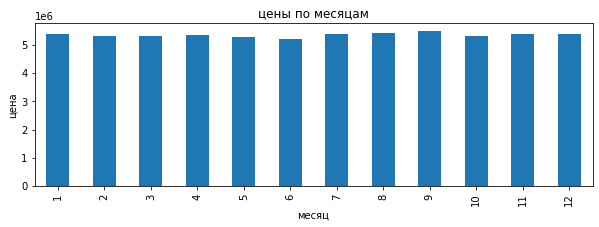

In [89]:
(data
 .groupby(by='first_day_exposition_month')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(10,3), title='цены по месяцам', xlabel='месяц', ylabel='цена')
)
plt.show()

Видно, что от месяца цена не зависит.

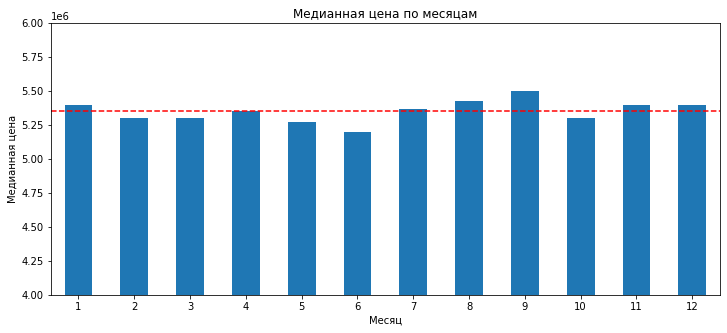

In [109]:
# Код ревбьюера
ax = data.groupby('first_day_exposition_month')['last_price'].median()\
    .plot(kind = 'bar', rot = 0, xlabel = 'Месяц', ylabel = 'Медианная цена',
         figsize = (12, 5))
ax.axhline(data['last_price'].median(), color = "red", linestyle = 'dashed')
plt.title('Медианная цена по месяцам')
plt.ylim(4000000, 6000000)
plt.show()

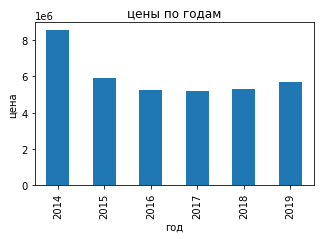

In [90]:
(data
 .groupby(by='first_day_exposition_year')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(5,3), title='цены по годам', xlabel='год', ylabel='цена')
)
plt.show()

В 2014 цена была максимальной на отрезке времени 2014-2019.

#### Посчитайте среднюю цену одного квадратного метра

In [91]:
pivot = data.pivot_table(index='locality_name', values='last_price_m2', aggfunc={'count', 'mean'}).sort_values(by='count', ascending=0)
display (pivot.head(10))
display("Самая высокая цена:")
display (pivot.head(1))
display("Самая низкая цена:")
display (pivot.head(10).tail(1))

,count,mean
locality_name,,
Санкт-Петербург,11614,111226.314338
поселок Шушары,280,74184.335786
Всеволожск,274,66191.538139
Пушкин,266,102851.417895
Колпино,253,72331.048261
Гатчина,221,67357.710136
поселок Мурино,210,78151.652667
Выборг,188,56913.116277
поселок Парголово,157,84118.258599


'Самая высокая цена:'

,count,mean
locality_name,,
Санкт-Петербург,11614,111226.314338


'Самая низкая цена:'

,count,mean
locality_name,,
Петергоф,142,84205.42493


#### Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра

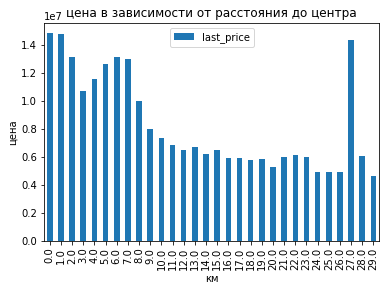

In [92]:
spb_price_per_km = data.query('locality_name == "Санкт-Петербург"').pivot_table (index='cityCenters_nearest_km', values=['last_price'])
spb_price_per_km.plot(title='цена в зависимости от расстояния до центра', kind='bar', xlabel='км', ylabel="цена");

Чем ближе квартира к центру, тем выше цена, за исключением двух пиков:
* в 3-4  км. от центра стоимость снижается 
* на 28 км. 

In [93]:
data.query('(locality_name == "Санкт-Петербург") and (cityCenters_nearest_km==27)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,first_day_exposition_weekday,first_day_exposition_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0,30000.0,128.0,193918.92,1,28,11,2017,другой,27.0


На 27 км. одна квартира за 14 млн. Тип диаграммы изменён на столбчатый - он более оказался показателен.

### Напишите общий вывод

Цель данной проектной работы: "научиться определять рыночную стоимость объектов недвижимости, установив параметры, влияющие на цену объектов".
#### Главные параметры, влияющие на цену объектов
В наибольшей степени на цену влияет общая площадь и удаление от центра. Это следует из таблицы корреляции (значение 0.77):

In [94]:
key_features.corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.770179,0.683420,0.588693
total_area,0.770179,1.000000,0.929888,0.640725
living_area,0.683420,0.929888,1.000000,0.452956
kitchen_area,0.588693,0.640725,0.452956,1.000000


Также с ценой коррелирует удалённость от центра. Чем ближе к центру - тем выше цена.

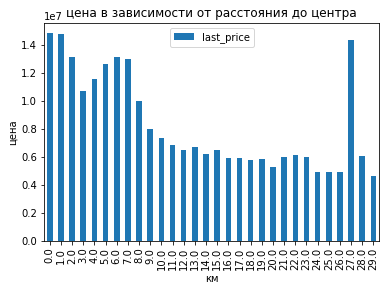

In [95]:
spb_price_per_km = data.query('locality_name == "Санкт-Петербург"').pivot_table (index='cityCenters_nearest_km', values=['last_price'])
spb_price_per_km.plot(title='цена в зависимости от расстояния до центра', kind='bar', xlabel='км', ylabel="цена");

Помимо этого цена коррелирует с количеством комнат (в то же время, количество комнат связано с общей площадью):

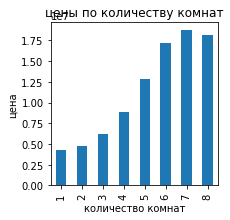

In [96]:
(data
 .groupby(by='rooms')['last_price']
 .median()
 .plot( y='last_price', kind='bar', figsize=(3,3), title='цены по количеству комнат', xlabel='количество комнат', ylabel='цена')
)
plt.show()

#### Рекомендации для сервиса
1. Инетрфейс сервиса дложен объяснять пользователю разницу между апартаментами и квартирами и требовать явное указание этого поля. Т. к. апартаменты это или квартира - важный признак в плане налогов и последующей возможной перепродажи, это поле - довольно "чувствительное" по значению. А сейчас доля неопределённости слишком велика (20924/23699=88%).
1. Параметр cityCenters_nearest, ponds_around3000, parks_around3000 должны заполняться автоматически. Почему в данных были пропуски? Разработчикам стоит разобраться и исправить это.
1. Почему сейчас в данных нет расстояния до ближайшего метро? Это также может быть важным фактором цены.
1. жилая площадь и площадь кухни бывает не указана (NaN). Её пришлось вычислить пропорционально средним значений в соседних данных. Хорошо бы, чтобы в этих полях не было пропусков.
1. Нужно иметь в данных этажность зданий (не должно быть пропусков, как сейчас). Это важный параметр для того, чтобы понять - последний ли этаж (такие квартиры стоят меньше). Не нужно заставлять пользователя заполнять это поле, эти поля уже должны быть в данны яндекс-карт.
1. Следующие поля сейчас имеют неверные типы - их прошлось исправлять, хотелось бы, чтобы в будущих отгрузках эти поля уже имели правильные типы:
    1. Поле first_day_exposition должно стать полем даты.
    1. floors_total ->int64
    1. is_apartment -> bool
    1. parks_around3000, ponds_around3000  -> int64
    1. days_exposition -> int64
1. В названиях типов насёлённых пунктов много неоднозначности, нужно обновить их следующим образом:
    1. садоводческое некоммерческое товарищество' -> 'садовое товарищество'
    1. 'поселок станции' -> 'поселок при железнодорожной станции'
    1. ['городской поселок', 'деревня', 'коттеджный поселок', 'поселок городского типа', 'поселок городского типа имени', 'поселок при железнодорожной станции', 'поселок станции'] -> поселок

#### Другие итоги проведённого исследования
1. Обработаны (заполнены) пропуски в следующих полях:
    1. is_apartment
    1. parks_nearest
    1. ponds_nearest
    1. balcony
    1. ceiling_height
    1. airports_nearest
    1. kitchen_area (вычислено из общей площади, по типичной пропорции)
    1. living_area (вычислено из общей площади, по типичной пропорции)
    1. floors_total
    1. locality_name
    1. ponds_around3000
    1. parks_around3000
1. для удобства рассчётов добавлены поля:
    1. стоимость m2
    1. день недели
    1. день месяца
    1. месяц
    1. год
    1. тип этажа (первый/последний/другое)
    1. расстояние до города в км
1. Удалены данные, аномально выделяющиеся из общего распределения:
    1.  с общей площадью <20 м2 и > более 300 м2
    1.  с жилой площадью <20 м2 и > более 200 м2
    1.  с площадью кухни > 40 м2
    1.  с ценой м2 > 400000
    1.  с комнатами <1 и > 8
    1.  с высотой потолков < 2 и > 5
    1.  с этажами > 30
1. Сроки продажи
    1. Согласно медиане, обычно продажа занимает около 95 дней. От 52 до 203 дней, согласно 1 и 3 квартилям.
    1. Рекордно быстрая продажа была совершена за 1 день, а рекордно долгая длилась 1580 дней.
    1. Можно сказать, что продажа быстрая если она совершена быстрее чем за 52 дня (1й квартиль). Необычно долгой можно назвать продажу выше 3го квартиля в 203 дня.
1. Выявилась интересная закономерность: на 30й, 45й, 60й и 90й день продажи резко возрастают.  Вероятно, это связано с периодами оплаты объявлений или с периодами их автоматического закрытия системой.
1. В 2014 цена была максимальной на отрезке времени 2014-2019.